In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def merge_history(hlist):
    """
    merge_history:
    Merges a list of training history dictionaries into a single dictionary.

    Parameters:
        hlist (list): a list of training history dictionaries

    Returns:
        dict: a single training history dictionary with the keys and values of all dictionaries in hlist
    """
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    """
    vis_training:
    Visualizes the training history of a model.

    Parameters:
        h (dict): a training history dictionary
        start (int, optional): the epoch at which to start plotting. Defaults to 1.

    Returns:
        None
    """
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

def convert_string_to_image(pixel_string, width, height, channels=3):
    # Convert the pixel string to a NumPy array
    pixel_values = np.fromstring(pixel_string, dtype=np.uint8, sep=' ')

    # Reshape the pixel array to the original image shape
    pixel_values = pixel_values.reshape((height, width, channels))

    # Create an image from the pixel array
    image = Image.fromarray(pixel_values)

    return image

In [4]:
df = pd.read_csv('./data.csv', delimiter=";")
print("The shape of data : ",df.shape)
print(df.head(10))

The shape of data :  (369, 2)
  short_circuit_faults                                             Pixels
0                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
1                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
2                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
3                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
4                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
5                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
6                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
7                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
8                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...
9                A&B50  5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 94 5 0 ...


In [5]:
df['short_circuit_faults'].unique()

array(['A&B50', 'A&C&B10', 'A&C&B30', 'A&C10', 'A&C30', 'A10', 'A30',
       'A50', 'Fan', 'Noload', 'Rotor-0'], dtype=object)

In [6]:
faults_label = {
    0:'A&B50',     #50% circuits 2 phases
    1:'A&C&B10',   #10% circuits 3 phases
    2:'A&C&B30',   #30% circuits 3 phases
    3:'A&C10',     #10% circuits 2 phases
    4:'A&C30',     #30% circuits 2 phases 
    5:'A10',       #10% circuits 1 phases
    6:'A30',       #30% circuits 1 phases   
    7:'A50',       #50% circuits 1 phases
    8:'Fan',       #Cooling
    9:'Noload',    #No load
    10:'Rotor-0'   #Healthy
}

In [6]:
#Calculates the proportions of each short circuit faults in a dataset and displays the results in a table
(df['short_circuit_faults'].value_counts() / df.shape[0]).to_frame().sort_index().T

,A&B50,A&C&B10,A&C&B30,A&C10,A&C30,A10,A30,A50,Fan,Noload,Rotor-0
short_circuit_faults,0.102981,0.084011,0.113821,0.084011,0.102981,0.092141,0.100271,0.094851,0.075881,0.067751,0.081301


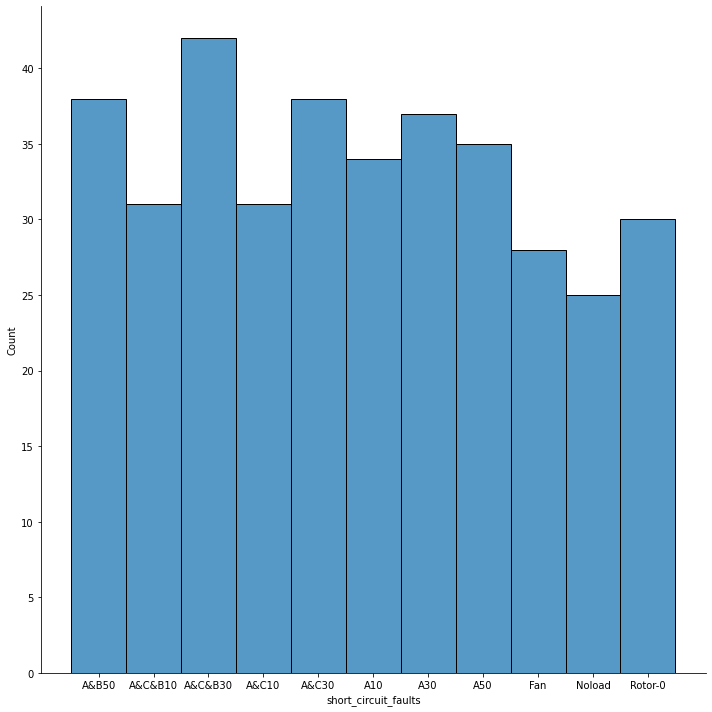

In [7]:
# Plot the distribution of short circuit faults
sns.displot(df, x=df['short_circuit_faults'], height=10)

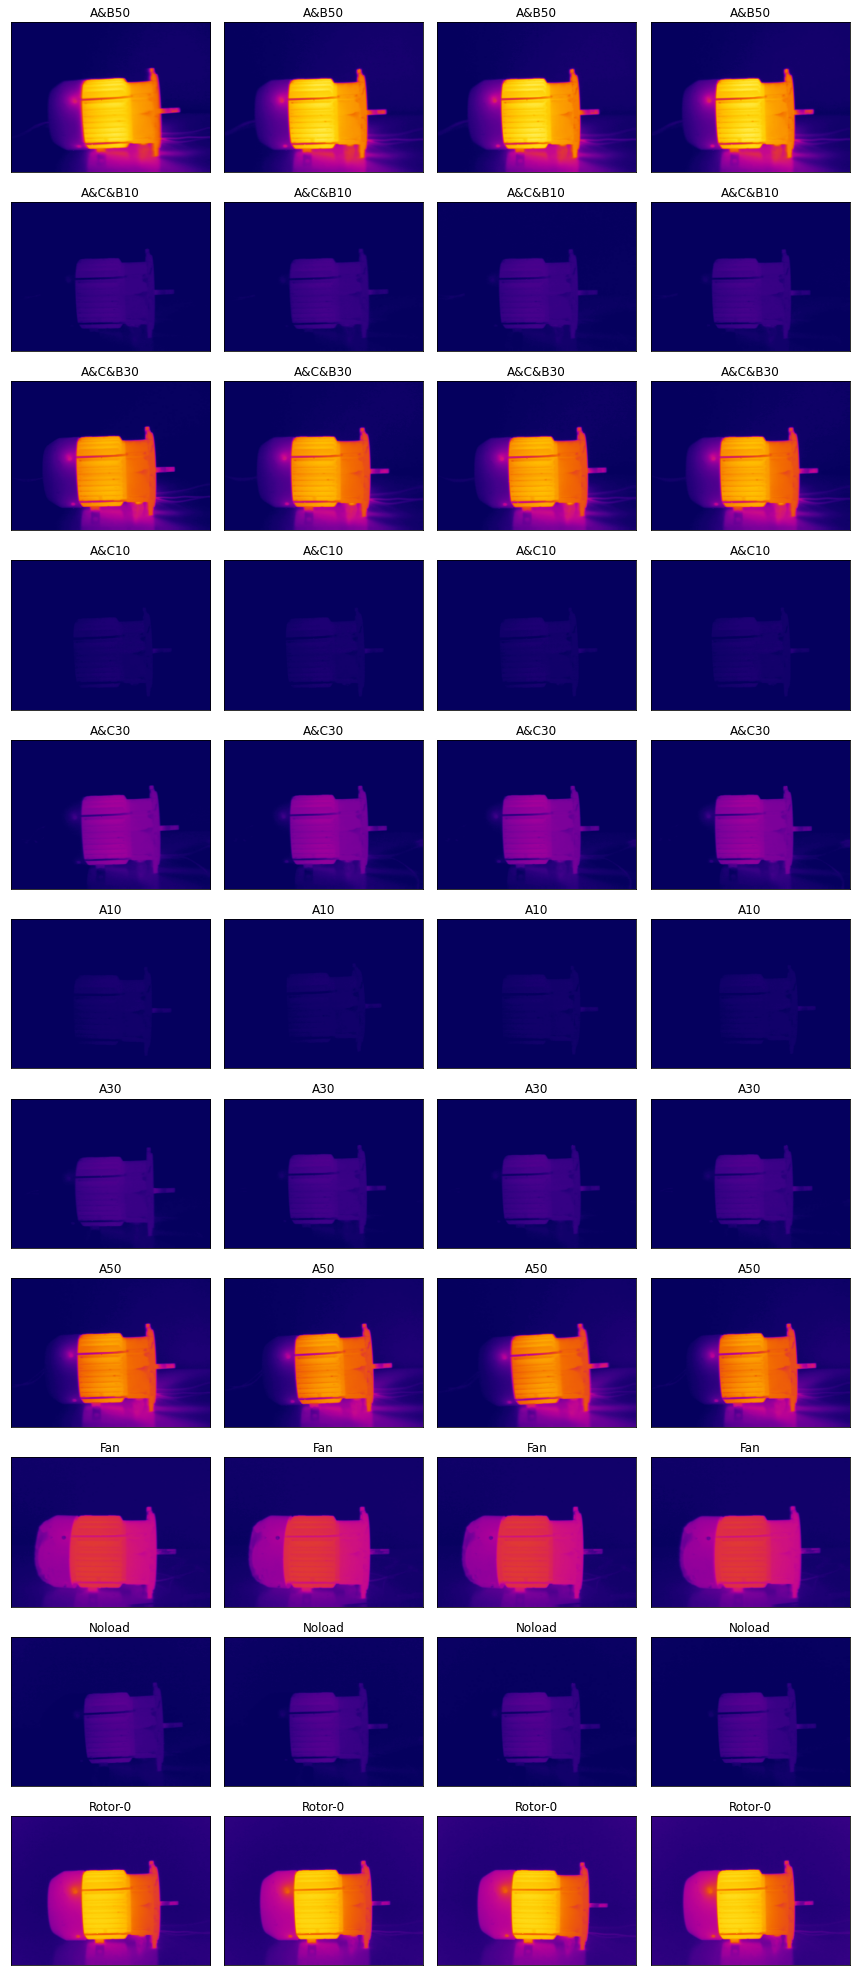

In [8]:
#Create a figure that contains 11x7 grid of subplots
fig = plt.figure(1, (12,30))
k=0

a = 4 # number of images peer label
#Loop through each short circuit faults label in the training data
for label in sorted(df['short_circuit_faults'].unique()):
    for j in range(a):
        
        #Generate a new subplot for each image of the short circuit faults label
        
        # Loop through each row in the dataframe for the short circuit faults label
        px = df[df['short_circuit_faults']==label].Pixels.iloc[k%df['short_circuit_faults'].value_counts().min()]
        
        # Create a numpy array from the pixel values, which is reshaped as 240x320
        px = convert_string_to_image(px, 320, 240, channels=3)
        
        k += 1
        ax = plt.subplot(df['short_circuit_faults'].unique().size + 1, a, k)
        
        #Plot the image, set title, and remove ticks
        ax.imshow(px, cmap="hot")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
        
        #Adjust layout to ensure images display properly
        plt.tight_layout()

In [7]:
from sklearn.preprocessing import LabelEncoder       # for encoding categorical labels
from keras.utils import np_utils        # for one-hot encoding target variables

data = df.copy()
# Convert the strings to np arrays reshaped as 320x240x3 with casting to integer 
# where the values are between entre 0 et 255
df['Pixels'] = [np.fromstring(x, dtype=np.uint8, sep=' ').reshape(-1, 240, 320, 3) for x in df["Pixels"]]

# Create an array of all the images
img_array = np.concatenate(df.Pixels)

# Create label encoder
le = LabelEncoder()

# Encode labels using fit_transform method for LabelEncoder() class 
# with transforming each emotion to integer values.
 
img_labels = le.fit_transform(df['short_circuit_faults'])

# Convert labels to categorical
#This means that each label is represented 
#by a binary vector of size 11

img_labels = np_utils.to_categorical(img_labels)

In [8]:
df.head(10)

,short_circuit_faults,Pixels
0,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
1,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
2,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
3,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
4,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
5,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
6,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
7,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
8,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."
9,A&B50,"[[[[ 5 0 94], [ 5 0 94], [ 5 0 94], [ 5 0 ..."


In [13]:
print('Pixel Shape: ', img_array.shape)
print('Label Shape: ', img_labels.shape)

Pixel Shape:  (369, 240, 320, 3)
Label Shape:  (369, 11)


In [6]:
from sklearn.model_selection import train_test_split # for splitting data into training and testing sets

# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, 
                                                      # Shuffle the data and stratify it
                                                      shuffle=True, stratify=img_labels, 
                                                      # Choose the test size percentage
                                                      test_size=0.2, 
                                                      # Set the random state
                                                      random_state=42)

print("Shapes of train data :", X_train.shape, y_train.shape)
print("Shapes of validation data :", X_valid.shape, y_valid.shape)

Shapes of train data : (295, 240, 320, 3) (295, 11)
Shapes of validation data : (74, 240, 320, 3) (74, 11)


In [12]:
# Normalize datasets
# such that the pixel values are between 0 and 1, 
#by diving them by their maximum value: 255
Xs_train = X_train / 255
Xs_valid = X_valid / 255

**Load Base model**

In [7]:
import tensorflow as tf
from tensorflow.keras import optimizers          # for setting the optimization algorithm for the model
from tensorflow.keras.models import Sequential   # for creating a sequential model
from tensorflow.keras.layers import *            # for creating layers in the model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau  # for setting callbacks to control training
from tensorflow.keras.preprocessing.image import ImageDataGenerator                # for generating additional training data through image augmentation


In [8]:
datagen = ImageDataGenerator(
    zoom_range=0.2, # Randomly zoom image 
    rotation_range=30, # Randomly rotate image
    width_shift_range=0.2, # Randomly shift image horizontally
    height_shift_range=0.2, # Randomly shift image vertically
    shear_range=0.2 # Randomly apply shearing transformation
)

# Create a generator to perform data augmentations for traing data
#which is used to iterate over the transformed images in batches, 
#where the "batch_size" parameter specifies the number images to include in each batch.
train_augemented_data = datagen.flow(X_train,
                               y_train,
                               batch_size=294,
                               shuffle=True)

valid_augemented_data = datagen.flow(X_valid,
                               y_valid,
                               batch_size=74,
                               shuffle=True)

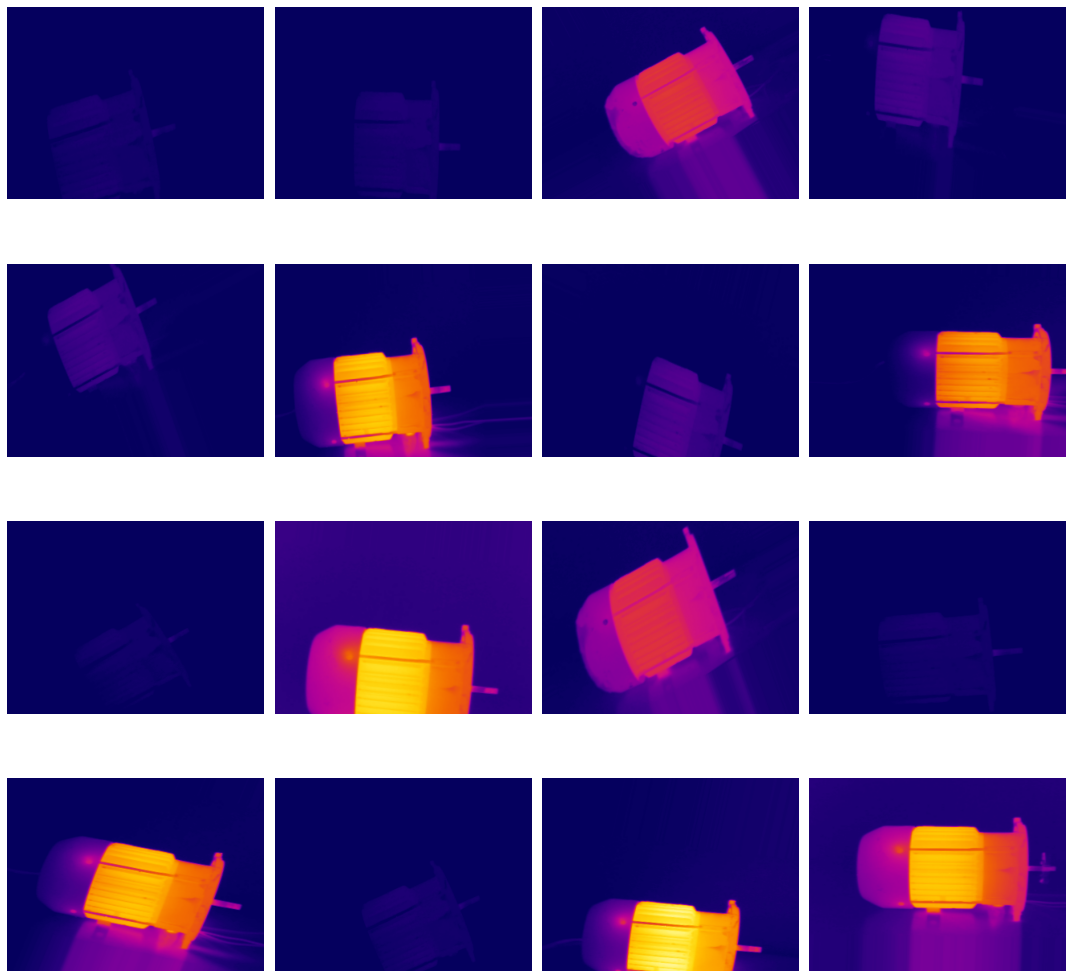

In [59]:
#############
## Augemented Training Images ##
#######
# Retrieve a batch of augmented images and labels
images, labels = train_augemented_data.next()

# Display the augmented images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for img, ax in zip(images, axes):
    img = img.astype(np.uint8)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

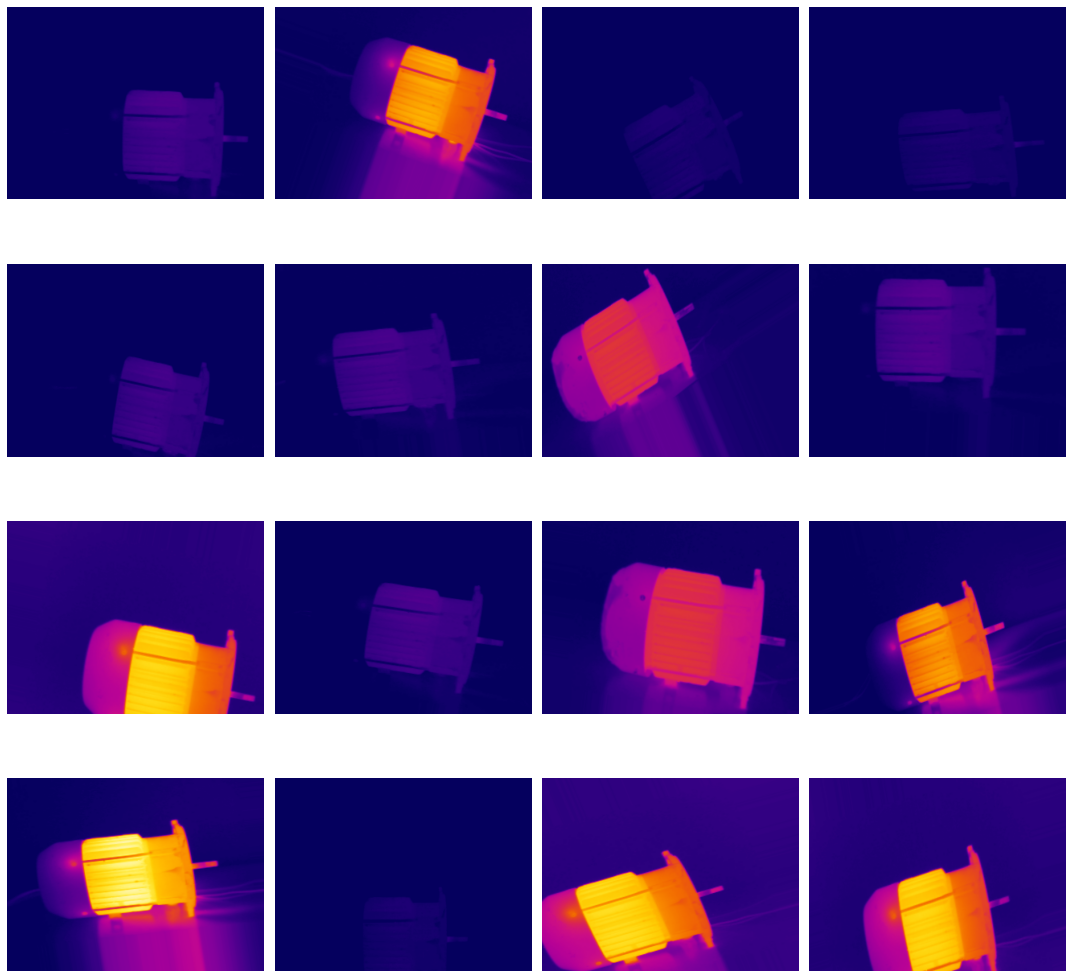

In [60]:
#############
## Augemented Validation Images ##
#######
# Retrieve a batch of augmented images and labels
images, labels = valid_augemented_data.next()

# Display the augmented images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for img, ax in zip(images, axes):
    img = img.astype(np.uint8)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

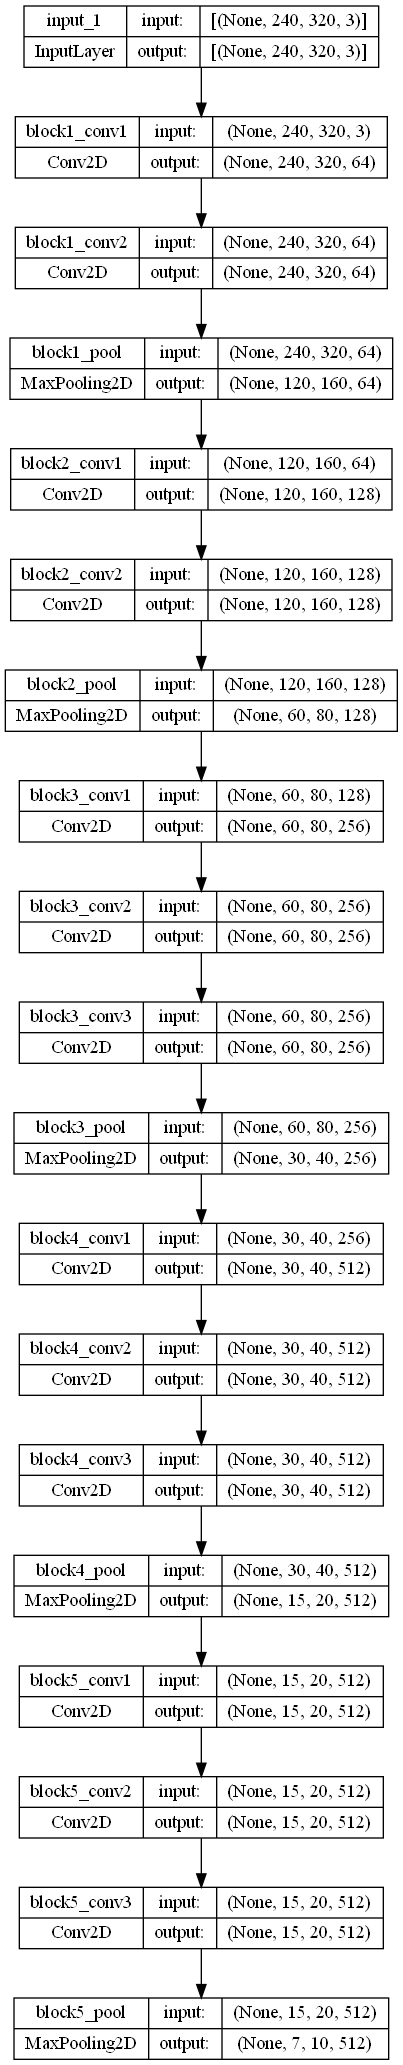

In [9]:
#Create a VGG16 model with imagenet weights
base_model = tf.keras.applications.VGG16(
    input_shape = (240, 320, 3), 
    include_top = False, 
    weights = 'imagenet'
)

#Set the model to non-trainable
base_model.trainable = False

#Plot the architecture of the model 
#with showing the shapes of the input and ouput tensors for each layer
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [20]:
# Display a summary of the architecture of the keras model defined 
#by including, for each layer:
# - the type of layers,
# - The forms of input and ouput tensors, 
# - The number of parameters, 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0     

In [10]:
from tensorflow import keras

# Set the first 15 layers of the model to be non-trainable
for layer in base_model.layers[:15]:
    layer.trainable = False
    
# Get the output from the base model
x = base_model.output

# Flatten the output dimensions to be used in the fully connected layers
x = Flatten()(x)

# Create a fully connected layer 
#with 512 neurons and Rectified linear activation function
x = Dense(512, activation='relu')(x)

# Add a dropout layer to reduce overfitting
x = Dropout(0.5)(x)

# Create a second fully connected layer with 256 neurons and ReLU activation function
x = Dense(256, activation='relu')(x)

# Create an output layer with 7 neurons and Softmax activation
x = Dense(11, activation='softmax')(x)

# Create the model
cnn = keras.Model(inputs=base_model.input, outputs=x)

# Print out the layer names and whether or not they are trainable
for i, layer in enumerate(cnn.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten True
20 dense True
21 dropout True
22 dense_1 True
23 dense_2 True


In [142]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# Create checkpoint callback
checkpoint_path = "thermal_images_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 6,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training



In [12]:
# Set Adam optimizer with learning rate 0.0001
opt = tf.keras.optimizers.Adam(0.0001)

# Compile the model using categorical crossentropy loss, Adam optimizer and accuracy as metrics
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [145]:
%%time

# Fit the model on the training data and validate it on the validation data

h1 = cnn.fit(
    X_train, y_train,
    steps_per_epoch = 30,
    epochs=30,
    validation_data=(X_valid, y_valid),
    validation_steps = 10,
    shuffle=True,
    verbose=1,
)

Epoch 1/30
30/30 [==============================] - 76s 3s/step - loss: 5.1240 - accuracy: 0.4305 - val_loss: 0.9084 - val_accuracy: 0.7568
Epoch 2/30
30/30 [==============================] - 83s 3s/step - loss: 1.1359 - accuracy: 0.7797 - val_loss: 0.2551 - val_accuracy: 0.9459
Epoch 3/30
30/30 [==============================] - 91s 3s/step - loss: 0.7177 - accuracy: 0.8644 - val_loss: 0.2603 - val_accuracy: 0.9189
Epoch 4/30
30/30 [==============================] - 105s 4s/step - loss: 0.3321 - accuracy: 0.9153 - val_loss: 0.1140 - val_accuracy: 0.9730
Epoch 5/30
30/30 [==============================] - 106s 4s/step - loss: 0.8191 - accuracy: 0.8678 - val_loss: 0.1186 - val_accuracy: 0.9459
Epoch 6/30
30/30 [==============================] - 107s 4s/step - loss: 0.2465 - accuracy: 0.9492 - val_loss: 0.1104 - val_accuracy: 0.9459
Epoch 7/30
30/30 [==============================] - 113s 4s/step - loss: 0.2207 - accuracy: 0.9356 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 8/30
30/30

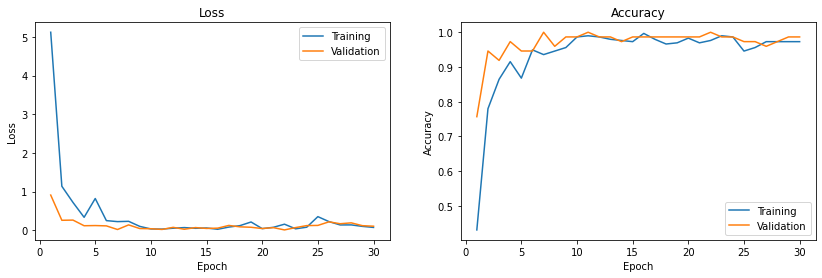

In [146]:
#Plot the learning curve for training and validation
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [32]:
results = cnn.evaluate(X_valid, y_valid, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.10180
Test Accuracy: 98.65%


In [33]:
# Predict the label of the test_images
pred = cnn.predict(X_valid)
pred = np.argmax(pred,axis=1)

# Map the label
pred = [faults_label[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

3/3 [==============================] - 15s 5s/step
The first 5 predictions: ['A&C30', 'Rotor-0', 'A&B50', 'Fan', 'A&C30']


In [34]:
true_labels = np.array([faults_label[i] for i in np.argmax(y_valid, axis=1)])

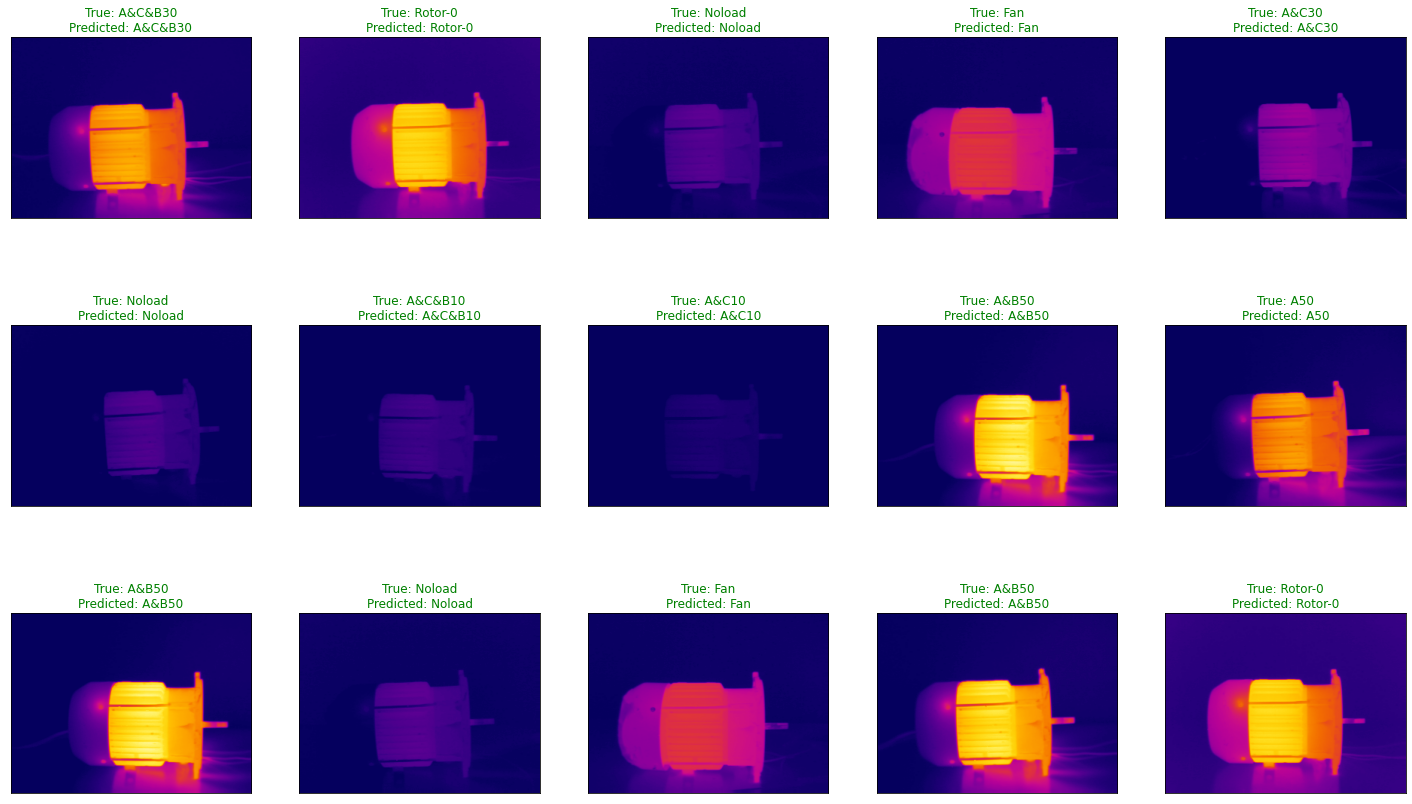

<Figure size 432x288 with 0 Axes>

In [35]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(X_valid) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X_valid[random_index[i]])
    if true_labels[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {true_labels[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
y_test = list(true_labels.copy())
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
A&B50,1.000000,1.000000,1.000000,8.000000
A&C&B10,1.000000,1.000000,1.000000,6.000000
A&C&B30,1.000000,1.000000,1.000000,8.000000
A&C10,1.000000,1.000000,1.000000,6.000000
A&C30,0.888889,1.000000,0.941176,8.000000
A10,1.000000,1.000000,1.000000,7.000000
A30,1.000000,0.857143,0.923077,7.000000
A50,1.000000,1.000000,1.000000,7.000000
Fan,1.000000,1.000000,1.000000,6.000000
Noload,1.000000,1.000000,1.000000,5.000000


In [37]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

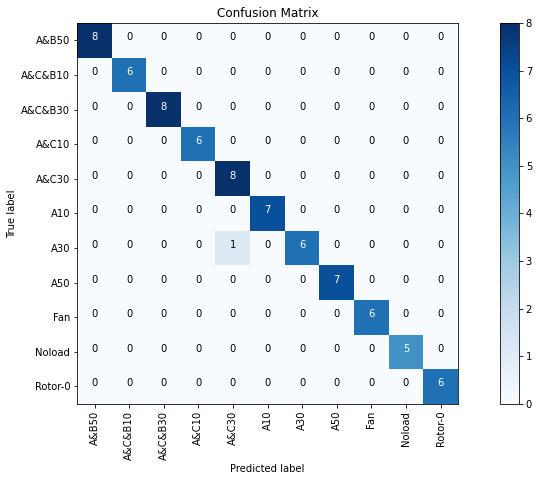

In [38]:
make_confusion_matrix(y_test, pred, list(faults_label.values()))

In [154]:
#cnn.save("CNN_v1.h5")

**Version 1 du model VGG16**

In [42]:
# Set the first 15 layers of the model to be non-trainable
for layer in base_model.layers:
    layer.trainable = True
    
# Get the output from the base model
x = base_model.output

# Flatten the output dimensions to be used in the fully connected layers
x = Flatten()(x)

# Create a fully connected layer 
#with 512 neurons and Rectified linear activation function
x = Dense(512, activation='relu')(x)

# Add a dropout layer to reduce overfitting
x = Dropout(0.5)(x)

# Create a second fully connected layer with 256 neurons and ReLU activation function
x = Dense(256, activation='relu')(x)

# Create an output layer with 7 neurons and Softmax activation
x = Dense(11, activation='softmax')(x)

# Create the model
cnn1 = keras.Model(inputs=base_model.input, outputs=x)

# Print out the layer names and whether or not they are trainable
for i, layer in enumerate(cnn1.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_3 True
20 dense_9 True
21 dropout_3 True
22 dense_10 True
23 dense_11 True


In [43]:
# Set Adam optimizer with learning rate 0.0001
opt = tf.keras.optimizers.Adam(0.0001)

# Compile the model using categorical crossentropy loss, Adam optimizer and accuracy as metrics
cnn1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [44]:
%%time

# Fit the model on the training data and validate it on the validation data

h2 = cnn1.fit(
    X_train, y_train,
    #train_augemented_data,
    #steps_per_epoch = len(train_augemented_data),
    steps_per_epoch = 30,
    epochs=30,
    validation_data=(X_valid, y_valid),
    #validation_data=valid_augemented_data,
    #validation_steps=len(valid_augemented_data),
    shuffle=True,
    verbose=1,
)

Epoch 1/30
30/30 [==============================] - 261s 9s/step - loss: 2.9649 - accuracy: 0.1390 - val_loss: 2.0085 - val_accuracy: 0.2703
Epoch 2/30
30/30 [==============================] - 258s 9s/step - loss: 1.8928 - accuracy: 0.3458 - val_loss: 1.3817 - val_accuracy: 0.6081
Epoch 3/30
30/30 [==============================] - 256s 9s/step - loss: 1.5035 - accuracy: 0.4169 - val_loss: 0.8939 - val_accuracy: 0.7432
Epoch 4/30
30/30 [==============================] - 254s 8s/step - loss: 1.2654 - accuracy: 0.5153 - val_loss: 0.9714 - val_accuracy: 0.4865
Epoch 5/30
30/30 [==============================] - 250s 8s/step - loss: 0.9197 - accuracy: 0.6237 - val_loss: 0.5852 - val_accuracy: 0.7838
Epoch 6/30
30/30 [==============================] - 257s 9s/step - loss: 0.6972 - accuracy: 0.6949 - val_loss: 0.8377 - val_accuracy: 0.6081
Epoch 7/30
30/30 [==============================] - 252s 8s/step - loss: 0.7306 - accuracy: 0.6847 - val_loss: 0.4051 - val_accuracy: 0.7838
Epoch 8/30
30

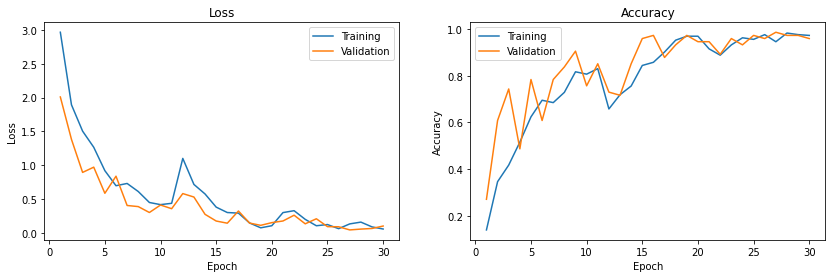

In [45]:
#Plot the learning curve for training and validation
history = h2.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 11s 3s/step


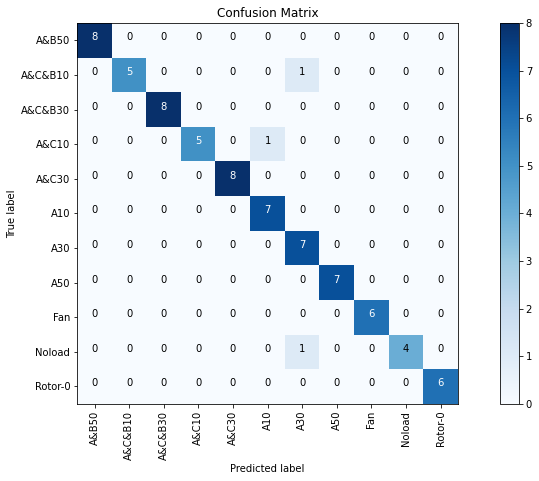

In [48]:
# Predict the label of the test_images
pred = cnn1.predict(X_valid)
pred = np.argmax(pred,axis=1)

# Map the label
pred = [faults_label[k] for k in pred]
true_labels = np.array([faults_label[i] for i in np.argmax(y_valid, axis=1)])
y_test = list(true_labels.copy())
make_confusion_matrix(y_test, pred, list(faults_label.values()))

In [49]:
#cnn.save("CNN1.h5")

In [ ]:
%%time

# Fit the model on the training data and validate it on the validation data

h3 = cnn.fit(
    #X_train, y_train,
    train_augemented_data,
    #steps_per_epoch = len(train_augemented_data),
    #steps_per_epoch = 30,
    epochs=10,
    #validation_data=(X_valid, y_valid),
    validation_data=valid_augemented_data,
    #validation_steps=len(valid_augemented_data),
    shuffle=True,
    verbose=1,
)

Epoch 1/10
1/2 [==============>...............] - ETA: 1s - loss: 14.1348 - accuracy: 0.0000e+00

In [ ]:
#Plot the learning curve for training and validation
history = h3.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()